In [1]:
from google.colab import files
uploaded = files.upload()

Saving HR_comma_sep.csv to HR_comma_sep.csv


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

In [4]:
csv_path = "HR_comma_sep.csv"
df = pd.read_csv(csv_path)


In [5]:
print("Rows,Cols:", df.shape)
print(df.head())

Rows,Cols: (14999, 10)
   satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0  

In [6]:
print(df.isnull().sum())

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64


In [7]:
print("salary unique:", df['salary'].unique())

salary unique: ['low' 'medium' 'high']


In [10]:
print("sales (department) unique sample:", df['Department'].unique()[:10])

sales (department) unique sample: ['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']


In [11]:
print(df.describe())

       satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_montly_hours  time_spend_company  Work_accident          left  \
count          14999.000000        14999.000000   14999.000000  14999.000000   
mean             201.050337            3.498233       0.144610      0.238083   
std               49.943099            1.460136       0.351719      0.425924   
min               96.000000            2.000000       0.000000      0.000000   
25%              156.000000            3.

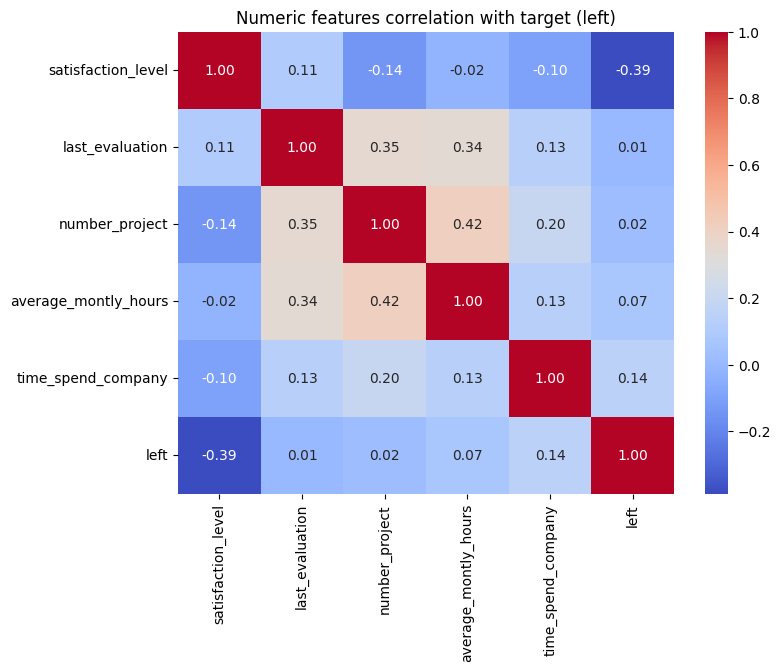

In [12]:
numeric_cols = ['satisfaction_level', 'last_evaluation', 'number_project',
                'average_montly_hours', 'time_spend_company']
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols + ['left']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Numeric features correlation with target (left)")
plt.show()

In [13]:
salary_retention = df.groupby('salary')['left'].agg(['count','sum'])
salary_retention['left_rate'] = salary_retention['sum'] / salary_retention['count']
print(salary_retention)

        count   sum  left_rate
salary                        
high     1237    82   0.066289
low      7316  2172   0.296884
medium   6446  1317   0.204313


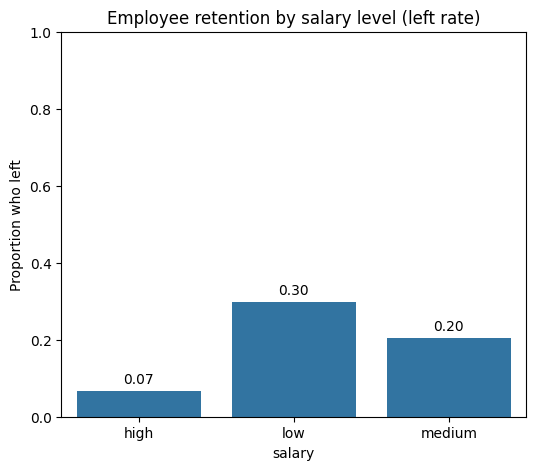

In [14]:
plt.figure(figsize=(6,5))
sns.barplot(x=salary_retention.index, y=salary_retention['left_rate'].values)
plt.ylabel("Proportion who left")
plt.title("Employee retention by salary level (left rate)")
plt.ylim(0, 1)
for i, v in enumerate(salary_retention['left_rate'].values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()


<Figure size 800x500 with 0 Axes>

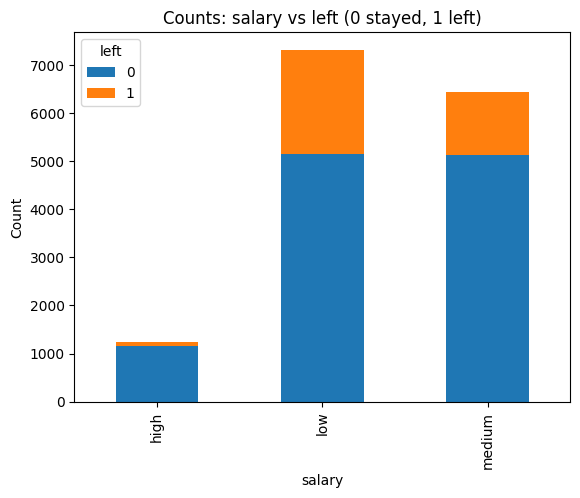

In [15]:
plt.figure(figsize=(8,5))
pd.crosstab(df['salary'], df['left']).plot(kind='bar', stacked=True)
plt.title("Counts: salary vs left (0 stayed, 1 left)")
plt.ylabel("Count")
plt.show()

In [17]:
dept_retention = df.groupby('Department')['left'].agg(['count','sum'])
dept_retention['left_rate'] = dept_retention['sum'] / dept_retention['count']
dept_retention_sorted = dept_retention.sort_values('left_rate', ascending=False)
print(dept_retention_sorted.head(10))

             count   sum  left_rate
Department                         
hr             739   215   0.290934
accounting     767   204   0.265971
technical     2720   697   0.256250
support       2229   555   0.248991
sales         4140  1014   0.244928
marketing      858   203   0.236597
IT            1227   273   0.222494
product_mng    902   198   0.219512
RandD          787   121   0.153748
management     630    91   0.144444


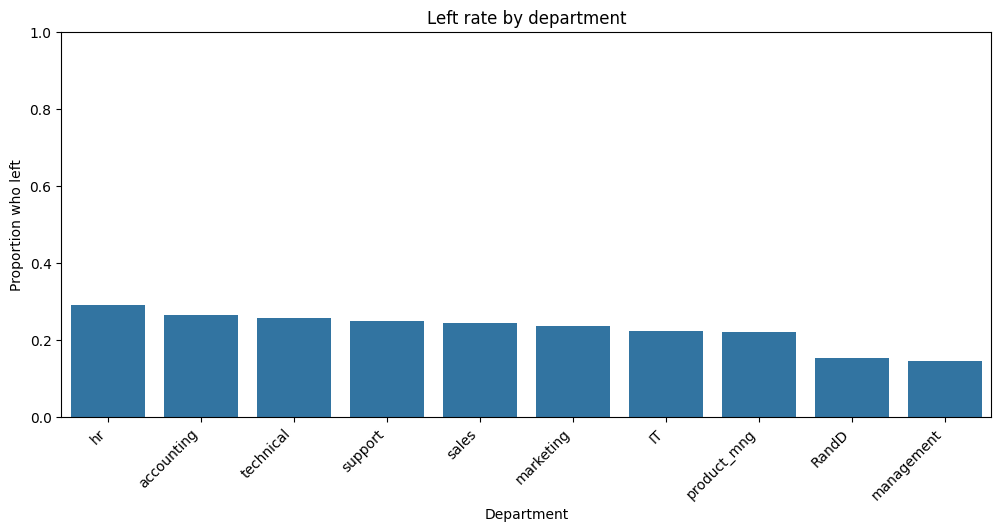

In [18]:
plt.figure(figsize=(12,5))
sns.barplot(x=dept_retention_sorted.index, y=dept_retention_sorted['left_rate'].values)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Proportion who left")
plt.title("Left rate by department")
plt.ylim(0, 1)
plt.show()


<Figure size 1200x500 with 0 Axes>

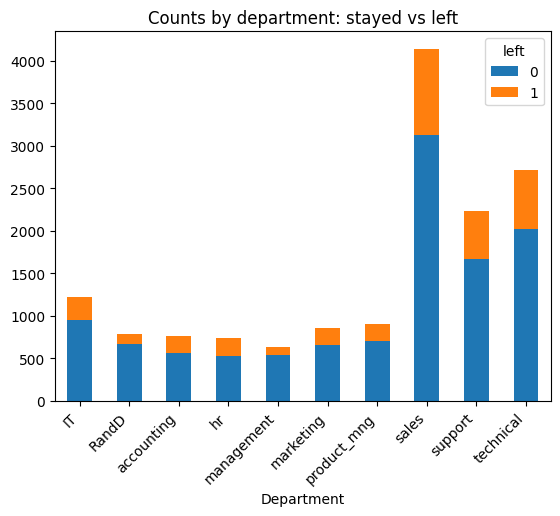

In [19]:
plt.figure(figsize=(12,5))
pd.crosstab(df['Department'], df['left']).plot(kind='bar', stacked=True)
plt.xticks(rotation=45, ha='right')
plt.title("Counts by department: stayed vs left")
plt.show()

In [20]:
grouped = df.groupby('left')[numeric_cols].mean().T
print("Mean numeric features by left (0 stayed, 1 left):")
print(grouped)

Mean numeric features by left (0 stayed, 1 left):
left                           0           1
satisfaction_level      0.666810    0.440098
last_evaluation         0.715473    0.718113
number_project          3.786664    3.855503
average_montly_hours  199.060203  207.419210
time_spend_company      3.380032    3.876505


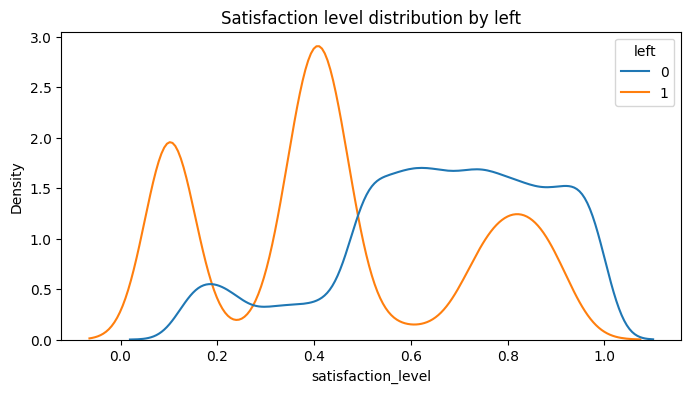

In [21]:
plt.figure(figsize=(8,4))
sns.kdeplot(data=df, x='satisfaction_level', hue='left', common_norm=False)
plt.title("Satisfaction level distribution by left")
plt.show()

In [23]:
features = ['satisfaction_level', 'last_evaluation', 'number_project',
            'average_montly_hours', 'time_spend_company',
            'Work_accident', 'promotion_last_5years', 'salary']

X = df[features].copy()
y = df['left']

In [24]:
ordinal_enc = OrdinalEncoder(categories=[['low','medium','high']])
X['salary_ord'] = ordinal_enc.fit_transform(X[['salary']])
X.drop(columns=['salary'], inplace=True)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [26]:

num_cols = ['satisfaction_level', 'last_evaluation', 'number_project',
            'average_montly_hours', 'time_spend_company']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [27]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [28]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]


In [29]:
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [30]:
print("Accuracy:", acc)
print("ROC AUC:", roc_auc)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)


Accuracy: 0.7976666666666666
ROC AUC: 0.8247817062082926
Confusion Matrix:
 [[2126  160]
 [ 447  267]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.88      2286
           1       0.63      0.37      0.47       714

    accuracy                           0.80      3000
   macro avg       0.73      0.65      0.67      3000
weighted avg       0.78      0.80      0.78      3000



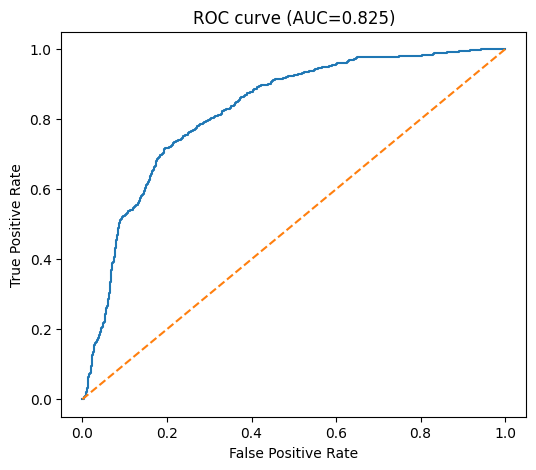

In [31]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curve (AUC={roc_auc:.3f})")
plt.show()

In [32]:
coeffs = pd.Series(clf.coef_[0], index=X_train.columns).sort_values()
print("Logistic regression coefficients (sorted):")
print(coeffs)

Logistic regression coefficients (sorted):
Work_accident           -1.518187
promotion_last_5years   -1.276552
satisfaction_level      -1.018075
salary_ord              -0.695385
number_project          -0.389466
last_evaluation          0.121337
average_montly_hours     0.223862
time_spend_company       0.375890
dtype: float64
